# Distribution of the data related by the following paper: 

### Investigating the effect of grain structure on compressive response of open-cell metal foam using high-fidelity crystal-plasticity modeling 

__Authors:__  _Dongfang Zhao, Kristoffer E. Matheson, Brian R. Phung, Steve Petruzza, Michael W. Czabaj, Ashley D. Spear_ 

__Published in:__  Materials Science and Engineering, Volume 812, 2021, 140847, ISSN 0921-5093

https://doi.org/10.1016/j.msea.2021.140847

https://www.sciencedirect.com/science/article/pii/S0921509321001167

In [1]:
def InstallPrerequisites():

    # Pre-requirements: install all the python libraries needed to run this exemple.
    # You may need to restart the kernel if the process catches a missing library to be installed. 
    import os,sys

    # specific prerequisite (this may need to be completed)
    !"{sys.executable}" -m pip  install --upgrade OpenVisus
    !"{sys.executable}" -m OpenVisus configure 

    # general prerequisites
    !"{sys.executable}" -m pip install PIL
    !"{sys.executable}" -m pip install urllib
    !"{sys.executable}" -m pip install matplotlib
    !"{sys.executable}" -m pip install mpl_interactions
    !"{sys.executable}" -m pip install ipywidgets
    !"{sys.executable}" -m pip install ipympl 
    !"{sys.executable}" -m pip install ipycanvas
    !"{sys.executable}" -m jupyter nbextension enable --py widgetsnbextension

    print("WARNING: you probably need to restart Jupyter")
    
InstallPrerequisites()

Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
144019052 Kernel:251 16364:44788 setting VISUS_HOME C:\Users\Vlaerio's PC\Documents/visus from home directory
144019053 Kernel:341 16364:44788 VERSION GIT_REVISION 0b54bd2 VisusHome C:\Users\Vlaerio's PC\Documents/visus BinaryDirectory C:/Users/Vlaerio's PC/AppData/Roaming/Python/Python37/site-packages/OpenVisus/bin CurrentWorkingDirectory  D:/visus-cache
144019053 VisusDbPy:77 16364:44788 Registering PyMultipleDataset
Starting OpenVisus C:\Users\Vlaerio's PC\AppData\Roaming\Python\Python37\site-packages\OpenVisus\__init__.py 3.7.9 (tags/v3.7.9:13c94747c7, Aug 17 2020, 18:58:18) [MSC v.1900 64 bit (AMD64)] sys.version_info(major=3, minor=7, micro=9, releaselevel='final', serial=0) ...
-m OpenVisus configure []
sys.executable c:\program files\python37\python.exe is_conda False
Executing command ['c:\\program files\\python37\\python.e

Defaulting to user installation because normal site-packages is not writeable


ERROR: Could not find a version that satisfies the requirement PIL (from versions: none)
ERROR: No matching distribution found for PIL


Defaulting to user installation because normal site-packages is not writeable


ERROR: Could not find a version that satisfies the requirement urllib (from versions: none)
ERROR: No matching distribution found for urllib


Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable


Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [1]:
import os,sys
import random

from PIL import Image
from urllib.request import urlopen
import matplotlib.pyplot as plt
from ipywidgets import *
from IPython.display import display

%matplotlib notebook

sys.path.append(r"C:\projects\OpenVisus\build\RelWithDebInfo")
from OpenVisus import *
print(os.getcwd())

Starting OpenVisus C:\projects\OpenVisus\build\RelWithDebInfo\OpenVisus\__init__.py 3.8.6 (tags/v3.8.6:db45529, Sep 23 2020, 15:52:53) [MSC v.1927 64 bit (AMD64)] sys.version_info(major=3, minor=8, micro=6, releaselevel='final', serial=0) ...
C:\projects\OpenVisus\Samples\jupyter


In [2]:
def Assert(cond):
    if not cond:
        raise Exception("Assert failed")
        
def LoadImage(filename):
	if filename.startswith('http'):
		filename=urlopen(filename) 
	return numpy.asarray(Image.open(filename))


class CachedDataset(PyDataset):
    
    # constructor
    def __init__(self, args):
        self.local_filename=os.path.abspath(args["local"]).replace("\\","/")
        self.remote_url=args["url"]
        self.remote_access_type = args["access"]
        self.description=args["description"]
        
        print("local_filename"    ,self.local_filename)
        print("remote_url"        ,self.remote_url)
        print("remote_access_type",self.remote_access_type)
        print("description",       self.description)
        
        super().__init__(LoadDatasetCpp(self.remote_url))
        
        self.num_blocks = len(self.getFields()) * self.getTotalNumberOfBlocks() * len(self.getTimesteps().asVector())
        self.num_blocks_cached = 0

        self.stop_thread=False
        self.thread=None
        
        self.progress=None
        self.progress_display=None

        print("Database size",self.getWidth(),self.getHeight(),self.getDepth())
        print("Fields:",self.getFields())          
        
        print("Loaded cached dataset")
        
    # __del__
    def __del__(self):
        self.stopCaching()   
        
    # createAccess
    def createAccess(self, ):
        
        access_config="""
            <access type='multiplex'>
                    <access type='disk' chmod='rw' url='file://{}' />
                    <access type='{}' url='{}' chmod="r" /> 
            </access>  
        """.format(
            self.local_filename.replace("&","&amp;"),
            self.remote_access_type,
            self.remote_url.replace("&","&amp;")) 
        
        # print("Creating access",access_config)

        access= self.createAccessForBlockQuery(StringTree.fromString(access_config))

        # at this point the cache is enabled with the new local idx file
        Assert(os.path.isfile(self.local_filename))

        return access   

    # startCaching
    def startCaching(self, background=True):
        
        if background:
            self.thread = threading.Thread(target=self.startCaching, args=(False,))
            self.stop_thread=False
            self.thread.start()        
            return 

        print("start caching","...")
        
        access=self.createAccess()

        access.beginRead()
        for field in self.getFields():
            for blockid in range(self.getTotalNumberOfBlocks()): 
                for time in self.getTimesteps().asVector():
                    # print("Copying block","time",time,"field",field,"blockid",blockid,"...")
                    buffer =  self.readBlock(blockid, field=field, time=time, access=access)
                    self.num_blocks_cached += 1
                    self.updateProgress()
                    if self.stop_thread:
                        print("thread stopped")
                        access.endRead()
                        return
                        
        access.endRead()
        self.thread=None
        print("caching finished done")
        
    # stopCaching
    def stopCaching(self):
        print("stopping caching...")
        self.stop_thread=True
        if self.thread:
            self.thread.join()
            self.thread=None
    # getWidth
    def getWidth(self):
        p2=self.getLogicBox()[1]
        return p2[0]    
        
    # getHeight
    def getHeight(self):
        p2=self.getLogicBox()[1]
        return p2[1]   
        
    # getDepth
    def getDepth(self):
        p2=self.getLogicBox()[1]
        return p2[2]  
        
    # readSlice
    def readSlice(self,dir=0, offset=0,quality=-3, time=0, access=None):
        W,H,D=self.getWidth(), self.getHeight(), self.getDepth()
        x=[0,W] if dir!=0 else [offset,offset+1]
        y=[0,H] if dir!=1 else [offset,offset+1]
        z=[0,D] if dir!=2 else [offset,offset+1] 
        
        logic_box=self.getLogicBox(x,y,z)
        logic_box=BoxNi(PointNi(logic_box[0]),PointNi(logic_box[1]))
        ret=self.read(logic_box=logic_box, quality=quality,time=time,access = access)
        
        d,h,w=ret.shape
        if dir==0: ret=ret.reshape([d,h])
        if dir==1: ret=ret.reshape([d,w])
        if dir==2: ret=ret.reshape([h,w])
        return ret
        
    # setProgress
    def setProgress(self,progress, progress_display):
        self.progress=progress
        self.progress_display=progress_display   
        self.progress.min=0
        self.progress.max =self.num_blocks       

    # updateProgress
    def updateProgress(self):
                    
        if self.progress:
            self.progress.value = self.num_blocks_cached

        if self.progress_display:
            self.progress_display.value = (
                "Caching progress %.2f%% (%d/%d)" % (
                    100 * self.num_blocks_cached/self.num_blocks, 
                    self.num_blocks_cached,
                    self.num_blocks))                    

print("Utilities defined")

Utilities defined


In [3]:
sources = [
    {
        "url":"https://mghp.osn.xsede.org/vpascuccibucket1/visus-server-foam/visus.idx?compression=zip&layout=hzorder",
        "access":"CloudStorageAccess",
        "local": "./visus-cache/mghp.osn.xsede.org/foam/visus.idx",
        "description":'Open Storage Network (OSN) Pod'
    },
    {
        "url":"http://atlantis.sci.utah.edu/mod_visus?dataset=foam&compression=zip&layout=hzorder",
        "access":"network",
        "local": "./visus-cache/atlantis.sci.utah.edu/foam/visus.idx",
        "description":'University of Utah Campus Server'
    },
    {
        "url" : "https://s3.us-west-1.wasabisys.com/visus-server-foam/visus.idx?compression=zip&layout=hzorder",
        "access":"CloudStorageAccess",
        "local": "./visus-cache/s3.us-west-1.wasabisys.com/foam/visus.idx",
        "description": 'Wasabi Commercial Cloud Storage'
    }
]

db=CachedDataset(sources[0])

local_filename C:/projects/OpenVisus/Samples/jupyter/visus-cache/mghp.osn.xsede.org/foam/visus.idx
remote_url https://mghp.osn.xsede.org/vpascuccibucket1/visus-server-foam/visus.idx?compression=zip&layout=hzorder
remote_access_type CloudStorageAccess
description Open Storage Network (OSN) Pod
Database size 1055 1024 1024
Fields: ['data', 'dist']
Loaded cached dataset


Now you can run a background process that slowly copy blocks from remote location

# Example of querying some data and showing inside an image

<IPython.core.display.Javascript object>


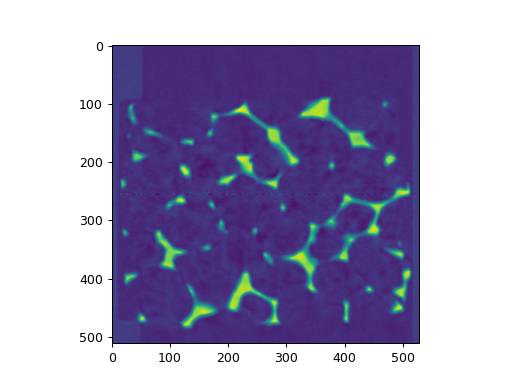

In [32]:
access=db.createAccess()
#data=db.readSlice(dir=0, offset=128, access=access, time=0)
#data=db.readSlice(dir=2, offset=db.getDepth()//2, access=access, time=0)
data=db.readSlice(dir=1, offset=db.getHeight()//2, access=access, time=0)

plt.figure()
im = plt.imshow(data)
display(im)

<IPython.core.display.Javascript object>


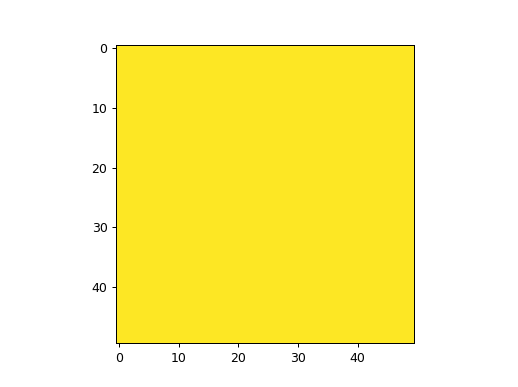

Dropdown(description='Data source:', layout=Layout(width='60%'), options=(('Open Storage Network (OSN) Pod', 0…

IntSlider(value=0, description='time (0-3)', layout=Layout(width='60%'), max=3)

Dropdown(description='Slice orthogonal to axis:', index=2, layout=Layout(width='60%'), options=(('X', 0), ('Y'…

IntSlider(value=500, description='slice', layout=Layout(width='60%'), max=1024)

IntSlider(value=-2, description='Resolution (coarse=-5,full=0)', layout=Layout(width='60%'), max=0, min=-5, st…

local_filename C:/projects/OpenVisus/Samples/jupyter/visus-cache/mghp.osn.xsede.org/foam/visus.idx
remote_url https://mghp.osn.xsede.org/vpascuccibucket1/visus-server-foam/visus.idx?compression=zip&layout=hzorder
remote_access_type CloudStorageAccess
description Open Storage Network (OSN) Pod
Database size 1055 1024 1024
Fields: ['data', 'dist']
Loaded cached dataset
start caching ...
2021-06-29 14:52:55.266646 readSlice direction 2 offset 512 quality -6 time 0
2021-06-29 14:52:55.275659 readSlice direction 2 offset 512 quality -6 time 0
2021-06-29 14:52:55.283648 readSlice direction 2 offset 512 quality -6 time 0
2021-06-29 14:52:55.291647 readSlice direction 2 offset 512 quality -15 time 0
2021-06-29 14:52:55.294648 readSlice direction 2 offset 512 quality -15 time 0


In [60]:
from datetime import datetime

class ExtractSliceWidget:
    
    # constructor
    def __init__(self, sources):
        self.sources=sources
        self.source=None
        self.db=None
        self.access=None   
        self.createGui()
        self.setSource(0)
        
    # onChangeSource
    def onChangeSource(self,__unused__):
        self.setSource(self.w["source"].value)
        
    # onChangeTime
    def onChangeTime(self,__unused__):
        self.refreshImage()

    # onChange
    def onChangeDirection(self,__unused__):
        direction=self.w["direction"].value
        dims=[self.db.getWidth(),self.db.getHeight(),self.db.getDepth()]
        self.w["slice"].min=0
        self.w["slice"].max=dims[direction]-1
        self.w["slice"].description="slice (0-{})".format(self.w["slice"].max)  
        self.refreshImage()
        
    # onChangeSlice
    def onChangeSlice(self,__unused__):
        self.refreshImage()
        
    # onChangeResolution
    def onChangeResolution(self,__unused__):
        self.refreshImage()        
        
    # createGui
    def createGui(self):

        LAYOUT_WIDTH = '60%'
        STYLE = {'description_width': 'initial'}

        plt.figure()
        self.image=plt.imshow(random.random((50,50))) 
        display(self.image)        
        
        self.w={}

        self.w["source"]=widgets.Dropdown(
            options=[(source["description"],I) for I,source in enumerate(self.sources)], 
            value=0,
            description='Data source:',
            style=STYLE,
            layout=Layout(width=LAYOUT_WIDTH))
        self.w["source"].observe(self.onChangeSource)

        self.w["time"]=widgets.IntSlider(
            value=0,
            min=0,
            max=3,
            step=1,
            description="time (0-3)",
            layout=Layout(width=LAYOUT_WIDTH))
        self.w["time"].observe(self.onChangeTime)

        self.w["direction"]=widgets.Dropdown(
            options=[('X', 0), ('Y', 1),  ('Z', 2)], 
            value=2,
            description='Slice orthogonal to axis:',
            style=STYLE,
            layout=Layout(width=LAYOUT_WIDTH))
        self.w["direction"].observe(self.onChangeDirection)

        self.w["slice"]=widgets.IntSlider(
            value=500,
            min=0,
            max=1024,
            step=1,
            description="slice",
            layout=Layout(width=LAYOUT_WIDTH))
        self.w["slice"].observe(self.onChangeSlice)

        self.w["resolution"]=widgets.IntSlider(
            value=-2,
            min=-5,
            max=0,
            step=1,
            description="Resolution (coarse=-5,full=0)",
            style=STYLE,
            layout=Layout(width=LAYOUT_WIDTH))
        self.w["resolution"].observe(self.onChangeResolution)

        self.w["progress"]=IntProgress(min=0, max=0,layout=Layout(width='70%'))
        self.w["progress_display"]=Label("Caching progress"+" "*24)
        
        display(self.w["source"])
        display(self.w["time"])
        display(self.w["direction"])
        display(self.w["slice"])
        display(self.w["resolution"])
        display(HBox([self.w["progress_display"], self.w["progress"]]))
    
    # setSource
    def setSource(self,source):
        
        if self.db is not None:
            self.db.stopCaching()
            self.db=None
            self.access=None

        self.source=source
        self.db=CachedDataset(self.sources[source])
        self.db.startCaching() 
        self.access=self.db.createAccess()   
        
        self.w['time'].value=0
        self.w['direction'].value=2
        self.w['slice'].value=self.db.getDepth()//2
        self.w['slice'].min=0
        self.w['slice'].max=self.db.getDepth()-1
        self.w["slice"].description="slice (0-{})".format(self.w["slice"].max)
        self.w['resolution'].value=-5
        
        self.db.setProgress(self.w["progress"],self.w["progress_display"])
            
    # refreshImage
    def refreshImage(self):
        time=self.w['time'].value
        direction=self.w['direction'].value
        slice=self.w['slice'].value
        resolution=self.w['resolution'].value
        
        # *** Valerio this must be wrong somewhere ***
        # scrgiorgio: resolution is a negative number
        quality=resolution*3
        denominator = int(2**(resolution*-1))
        offset=(slice//denominator)*denominator
        
        print(datetime.now(),"readSlice", "direction",direction,"offset",offset,"quality",quality,"time",time)
        data=self.db.readSlice(dir=direction,offset=offset,quality=quality,time=time,access=self.access)
        self.image.set_data(data)     
        plt.show()
        
slices=ExtractSliceWidget(sources)  
slices.refreshImage()